# Import the Necessary Libraries

In [1]:
# Data and Plotting
import pandas as pd
import numpy as np
import plotly.express as px
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, DetCurveDisplay

# Data encoding and Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, Normalizer
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# Dimensionality Reduction and Clustering Algorithms
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans

from sklearn.utils.class_weight import compute_sample_weight

# Data spliting and Cross Validation and Performance Metrics
from sklearn.model_selection import train_test_split as tts, StratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from sklearn.metrics import  make_scorer,  precision_score, accuracy_score

# models
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.neural_network import MLPClassifier as FNN

%matplotlib notebook

# Load the Dataset

In [2]:
data = pd.read_csv("Thyroid_Diff.csv")

X = data.drop("Recurred", axis=1)
y = data["Recurred"]
y = y.map({"No":0,"Yes":1})

X_train, X_test, y_train, y_test = tts(X, y, 
                                       train_size=.75, 
                                       random_state=321
                                      )
y_train.value_counts()

Recurred
0    210
1     77
Name: count, dtype: int64

# Define the Steps that are Common to the Methods

## a. The Data Preprocessing Step

In [3]:
# Define preprocessor
num_features = list(X.columns[:1])
cat_features = list(X.columns[1:])

# Define the numerical transformer
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ("scaler", MinMaxScaler())
])

# Define the categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown="ignore")),
])

# Define your ColumnTransformer (preprocessor)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ],
    remainder="passthrough",
)

# Compute sample weights based on class imbalance
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

## b. Define the Models and Metrics

In [4]:
# Define the models
models = {
    "RF": RFC(),
    "GB": GBC(),
    "SVM": SVC(probability=True),
    "LR": LR(),
    "KNN": KNN(),
    "FNN": FNN(),
}

# Define the list of metrics for model evaluation on test set
metrics = {
    "Balanced Accuracy": balanced_accuracy_score,
    "F1 Score": f1_score,
    "ROC AUC": roc_auc_score,
    "Sensitivity": recall_score,
    "Specificity": recall_score,
    "Precision": precision_score
}

# Define the list of metrics for models evaluation using 10-fold CV
ten_fold_CV_metrics = {
    "Balanced Accuracy": "balanced_accuracy",
    "F1 Score": "f1_macro",
    "ROC AUC": "roc_auc",
    "Sensitivity": make_scorer(recall_score, pos_label=1),
    "Specificity":  make_scorer(recall_score, pos_label=0),
    "Precision": "precision"
}

# Method 1: Dimensionality Reduction with PCA (PCA-Model Pipeline)

## a. Hyperparameter tuning, model building and evaluation on testing set

In [5]:
# These hyperparameters were tested before fine-tuning each one at finer granularity to improve model performance
param_grids = {
    "RF": {
        "clf__n_estimators": [400, 403],
        "clf__max_depth": [None],
        "clf__min_samples_split": [6, 7],
        "clf__min_samples_leaf": [4, 5],
        "clf__criterion": ["gini", "entropy", "log_loss"],
#         "clf__class_weight": [{0: 1, 1: 3}],
        "clf__max_features": ["log2"], 
    },
    "GB": {
        "clf__n_estimators": [150, 152],
        "clf__loss": ["exponential"],
        "clf__learning_rate": [0.35, 0.36],
        "clf__max_depth": [5, 6],
        "clf__criterion": ["squared_error", "friedman_mse",],
        "clf__tol": [1e-11, 1e-12]
    },
    "SVM": {
        "clf__C": [0.1, 0.12, 0.14],
        "clf__kernel": ["rbf", "sigmoid"],
        "clf__tol": [1e-1, 1e-2, 1e-3],
        
    },
    "LR": {
        "clf__C": [0.35, 0.36, 0.7],
        "clf__penalty": ["l1"],
        "clf__solver": ["liblinear"],

    },
    "KNN": {
        "clf__n_neighbors": [16, 17],
        "clf__weights": ["distance"],
        "clf__p": [2, 3, 4]
    },
    "FNN": {
        "clf__hidden_layer_sizes": [(300,), (130, 160)],
        "clf__max_iter": [10000, 12000],
        "clf__activation": ["relu", "identity"], 
        "clf__solver": ["adam", "sgd", "lbfgs"],
        "clf__learning_rate": ["constant", "adaptive"],
        "clf__tol": [1e-4, 1e-5],
        "clf__alpha": [0.1, 0.32, 1.0]
    }
}

# Set up Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=420)

# Define the best Dimensionality Reduction Technique from Method 3
pca = PCA(n_components=5)

# Store results
method_1_results = {}

for model_name, model in models.items():
    print(f"\rEvaluating {model_name}...", end="", flush=True)
    
    # Combine the dimensionality reduction, and model into a pipeline
    pipeline = Pipeline(
        steps = [
            ("preprocessor", preprocessor),
            ("pca", pca),
            ("clf", model),
        ])
    
    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=skf, scoring="roc_auc")
    if model_name in ["KNN", "FNN"]:
        grid_search.fit(X_train, y_train)
    else:
        grid_search.fit(X_train, y_train, clf__sample_weight=sample_weights)
    
    # Evaluate the model on the test set
    best_pipeline = grid_search.best_estimator_
    y_pred = best_pipeline.predict(X_test)
    y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metric_results = {}
    for metric_name, metric_func in metrics.items():
        if metric_name == "ROC AUC":
            metric_results[metric_name] = metric_func(y_test, y_pred_proba)
        elif metric_name == "Specificity":
            metric_results[metric_name] = metric_func(y_test, y_pred, pos_label=0)
        else:
            metric_results[metric_name] = metric_func(y_test, y_pred)
    
    # Store results
    method_1_results[model_name] = {
        "best Clf": best_pipeline,
        "Best Parameters": grid_search.best_params_,
        "Best ROC-AUC Score": grid_search.best_score_,
        "Metrics": metric_results
    }
    print(f"\rEvaluation completed for {model_name}")

print("All Evaluation completed.")

Evaluation completed for RF
Evaluation completed for GB
Evaluation completed for SVM
Evaluation completed for LR
Evaluation completed for KNN
Evaluation completed for FNN
All Evaluation completed.


In [6]:
# Print results
for model_name, result in method_1_results.items():
    print(f"\n{model_name} Results:")
    print(f"Best Parameters: {result['Best Parameters']}")
    print(f"Best ROC-AUC Score: {result['Best ROC-AUC Score']}")


RF Results:
Best Parameters: {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 6, 'clf__n_estimators': 400}
Best ROC-AUC Score: 0.9545039682539682

GB Results:
Best Parameters: {'clf__criterion': 'squared_error', 'clf__learning_rate': 0.36, 'clf__loss': 'exponential', 'clf__max_depth': 5, 'clf__n_estimators': 152, 'clf__tol': 1e-11}
Best ROC-AUC Score: 0.9509325396825398

SVM Results:
Best Parameters: {'clf__C': 0.1, 'clf__kernel': 'sigmoid', 'clf__tol': 0.001}
Best ROC-AUC Score: 0.9520039682539683

LR Results:
Best Parameters: {'clf__C': 0.36, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best ROC-AUC Score: 0.9482539682539682

KNN Results:
Best Parameters: {'clf__n_neighbors': 17, 'clf__p': 2, 'clf__weights': 'distance'}
Best ROC-AUC Score: 0.9439781746031747

FNN Results:
Best Parameters: {'clf__activation': 'relu', 'clf__alpha': 1.0, 'clf__hidden_layer_sizes': (300,), 'clf__learning_rate': 

In [7]:
performance_metrics = {metric_name: [] for metric_name in metrics.keys()}

for model_name, result in method_1_results.items():
    # print(model_name)
    for metric_name, score in result["Metrics"].items():
        # print(metric_name, ":", score)
        performance_metrics[metric_name].append(score)

df_performance = pd.DataFrame(performance_metrics)
df_performance.insert(0, "Models", [model_name for model_name in models])
df_performance = df_performance.round(3)
# df_performance.to_csv("../results/test set models performance using PCA.csv", index=False)
df_performance

,Models,Balanced Accuracy,F1 Score,ROC AUC,Sensitivity,Specificity,Precision
0,RF,0.914,0.866,0.978,0.935,0.892,0.806
1,GB,0.833,0.774,0.951,0.774,0.892,0.774
2,SVM,0.922,0.879,0.992,0.935,0.908,0.829
3,LR,0.938,0.896,0.992,0.968,0.908,0.833
4,KNN,0.912,0.885,0.985,0.871,0.954,0.900
5,FNN,0.945,0.909,0.987,0.968,0.923,0.857


# b. 10-fold CV using the entire dataset

In [8]:
# Set up Stratified K-Fold Cross-Validation
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=420)

# Define the best Dimensionality Reduction Technique
pca = PCA(n_components=5)

ten_fold_cv_results_method_1 = {}

for (model_name, model), results in zip(models.items(), method_1_results.values()):
    
    print(f"\rRunning {n_splits}-fold CV for {model_name}...", end="", flush=True)
    
    # Combine the dimensionality reduction, and model into a pipeline
    pipeline = Pipeline(
        steps = [
            ("preprocessor", preprocessor),
            ("pca", pca),
            ("clf", model),
        ])
    tuned_pipeline = pipeline.set_params(**results["Best Parameters"])
    
    cv_results = cross_validate(tuned_pipeline, X, y, cv=skf, scoring=ten_fold_CV_metrics, return_train_score=False)
    
    metric_ids = [metric_id for metric_id in cv_results.keys() if metric_id.startswith("test_")]
    scores = {name: cv_results[metric_id] for name, metric_id in zip(ten_fold_CV_metrics.keys(), metric_ids)}
    
    ten_fold_cv_results_method_1[model_name] = scores
    
    print(f"\rCompleted {n_splits}-fold CV for {model_name}")

print(f"\rAll {n_splits}-fold CV Completed")


performance_metrics = {metric_name: [] for metric_name in metrics.keys()}

for model_name, result in ten_fold_cv_results_method_1.items():
    for metric_name, score in result.items():
        performance_metrics[metric_name].append(np.mean(score))
        
df_performance = pd.DataFrame(performance_metrics)
df_performance.insert(0, "Model", [model_name for model_name in models])   
df_performance = df_performance.round(3)

# df_performance.to_csv("../results/10-fold CV performance using PCA.csv", index=False)
df_performance

Completed 10-fold CV for RF.
Completed 10-fold CV for GB.
Completed 10-fold CV for SVM.
Completed 10-fold CV for LR.
Completed 10-fold CV for KNN.
Completed 10-fold CV for FNN.
All 10-fold CV Completed


,Model,Balanced Accuracy,F1 Score,ROC AUC,Sensitivity,Specificity,Precision
0,RF,0.873,0.879,0.965,0.797,0.949,0.862
1,GB,0.866,0.870,0.953,0.797,0.935,0.843
2,SVM,0.864,0.854,0.963,0.825,0.902,0.772
3,LR,0.850,0.849,0.967,0.779,0.920,0.798
4,KNN,0.872,0.881,0.960,0.788,0.957,0.883
5,FNN,0.900,0.899,0.970,0.854,0.946,0.879


# Method 2: Dimensionality Reduction with tSVD (tSVD-Model Pipeline)

## a. Hyperparameter tuning, model building and evaluation on testing set

In [9]:
# These hyperparameters were tested before fine-tuning each one at finer granularity to improve model performance

param_grids = {
    "RF": {
        "clf__n_estimators": [300, 400],
        "clf__max_depth": [None],
        "clf__min_samples_split": [5, 6],
        "clf__min_samples_leaf": [2, 3],
        "clf__criterion": ["gini", "entropy", "log_loss"],
#         "clf__class_weight": [{0: 1, 1: 3}],
        "clf__max_features": ["log2"], 
    },
    "GB": {
        "clf__n_estimators": [120, 125, 150],
        "clf__loss": ["log_loss", "exponential"],
        "clf__learning_rate": [0.3, 0.35],
        "clf__max_depth": [3, 4, 5],
        "clf__criterion": ["friedman_mse", "squared_error"],
        "clf__tol": [1e-10, 1e-11]
    },
    "SVM": {
        "clf__C": [0.15, 0.25],
        "clf__kernel": [ "rbf", "sigmoid"],
        "clf__tol": [1e-2, 1e-3],
    },
    "LR": {
        "clf__C": [0.1, 0.2, 0.25],
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs", "liblinear", "saga", "sag"],
        "clf__tol": [1e-3, 1e-6, 1e-8],
        "clf__max_iter": [5000, 7000],
    },
    "KNN": {
        "clf__n_neighbors": [17, 18],
        "clf__weights": ["distance"],
        "clf__p": [3, 4, 5, 6]
    },
    "FNN": {
        "clf__hidden_layer_sizes": [(125, 155), (150,)],
        "clf__max_iter": [15000, 15050],
        "clf__activation": ["relu", "logistic", "identity"], 
        "clf__solver": ["adam", "sgd"],
        "clf__learning_rate": ["adaptive", "constant"],
        "clf__tol": [1e-2, 1e-3],
        "clf__alpha": [0.0001, 0.001]
    }
}

# Set up Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=420)

# Define the best Dimensionality Reduction Technique from Method 3
t_svd = TruncatedSVD(n_components=5)

# Store results
method_2_results = {}

for model_name, model in models.items():
    print(f"\rEvaluating {model_name}...", end="", flush=True)
    
    # Combine the preprocessing, dimensionality reduction, and model into a pipeline
    pipeline = Pipeline(
        steps = [
            ("preprocessor", preprocessor),
            ("t-svd", t_svd),
            ("clf", model),
        ])
    
    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=skf, scoring="roc_auc")
    if model_name in ["KNN", "FNN"]:
        grid_search.fit(X_train, y_train)
    else:
        grid_search.fit(X_train, y_train, clf__sample_weight=sample_weights)
    
    # Evaluate the model on the test set
    best_pipeline = grid_search.best_estimator_
    y_pred = best_pipeline.predict(X_test)
    y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metric_results = {}
    for metric_name, metric_func in metrics.items():
        if metric_name == "ROC AUC":
            metric_results[metric_name] = metric_func(y_test, y_pred_proba)
        elif metric_name == "Specificity":
            metric_results[metric_name] = metric_func(y_test, y_pred, pos_label=0)
        else:
            metric_results[metric_name] = metric_func(y_test, y_pred)
    
    # Store results
    method_2_results[model_name] = {
        "best Clf": best_pipeline,
        "Best Parameters": grid_search.best_params_,
        "Best ROC-AUC Score": grid_search.best_score_,
        "Metrics": metric_results
    }
    print(f"\rEvaluation completed for {model_name}")

print("Evaluation completed.")

Evaluation completed for RF
Evaluation completed for GB
Evaluation completed for SVM
Evaluation completed for LR
Evaluation completed for KNN
Evaluation completed for FNN
Evaluation completed.


In [10]:
# Print results
for model_name, result in method_2_results.items():
    print(f"\n{model_name} Results:")
    print(f"Best Parameters: {result['Best Parameters']}")
    print(f"Best ROC-AUC Score: {result['Best ROC-AUC Score']}")


RF Results:
Best Parameters: {'clf__criterion': 'log_loss', 'clf__max_depth': None, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'clf__n_estimators': 300}
Best ROC-AUC Score: 0.9330248698669751

GB Results:
Best Parameters: {'clf__criterion': 'friedman_mse', 'clf__learning_rate': 0.35, 'clf__loss': 'log_loss', 'clf__max_depth': 5, 'clf__n_estimators': 150, 'clf__tol': 1e-11}
Best ROC-AUC Score: 0.9341494762547394

SVM Results:
Best Parameters: {'clf__C': 0.25, 'clf__kernel': 'sigmoid', 'clf__tol': 0.01}
Best ROC-AUC Score: 0.9465587044534413

LR Results:
Best Parameters: {'clf__C': 0.1, 'clf__max_iter': 5000, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'clf__tol': 0.001}
Best ROC-AUC Score: 0.9451609793715057

KNN Results:
Best Parameters: {'clf__n_neighbors': 18, 'clf__p': 4, 'clf__weights': 'distance'}
Best ROC-AUC Score: 0.932494698284172

FNN Results:
Best Parameters: {'clf__activation': 'identity', 'clf__alpha': 0.001, 'clf__hidden_l

In [11]:
performance_metrics = {metric_name: [] for metric_name in metrics.keys()}

for model_name, result in method_2_results.items():
    # print(model_name)
    for metric_name, score in result["Metrics"].items():
        # print(metric_name, ":", score)
        performance_metrics[metric_name].append(score)

df_performance = pd.DataFrame(performance_metrics)
df_performance.insert(0, "Models", [model_name for model_name in models])
df_performance = df_performance.round(3)
# df_performance.to_csv("../results/test set models performance using tSVD.csv", index=False)
df_performance

,Models,Balanced Accuracy,F1 Score,ROC AUC,Sensitivity,Specificity,Precision
0,RF,0.929,0.892,0.984,0.935,0.923,0.853
1,GB,0.881,0.839,0.964,0.839,0.923,0.839
2,SVM,0.929,0.892,0.991,0.935,0.923,0.853
3,LR,0.938,0.896,0.994,0.968,0.908,0.833
4,KNN,0.912,0.885,0.988,0.871,0.954,0.900
5,FNN,0.960,0.951,0.989,0.935,0.985,0.967


## b. 10-fold CV using the entire dataset

In [12]:
# Set up Stratified K-Fold Cross-Validation
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=420)

# Define the best Dimensionality Reduction Technique from Method 3
tsvd = TruncatedSVD(n_components=5)

ten_fold_cv_results_method_2 = {}

for (model_name, model), results in zip(models.items(), method_2_results.values()):
    
    print(f"\rRunning {n_splits}-fold CV for {model_name}...", end="", flush=True)
    
    # Combine the dimensionality reduction, and model into a pipeline
    pipeline = Pipeline(
        steps = [
            ("preprocessor", preprocessor),
            ("pca", tsvd),
            ("clf", model),
        ])
    tuned_pipeline = pipeline.set_params(**results["Best Parameters"])
    
    cv_results = cross_validate(tuned_pipeline, X, y, cv=skf, scoring=ten_fold_CV_metrics, return_train_score=False)
    
    metric_ids = [metric_id for metric_id in cv_results.keys() if metric_id.startswith("test_")]
    scores = {name: cv_results[metric_id] for name, metric_id in zip(ten_fold_CV_metrics.keys(), metric_ids)}
    
    ten_fold_cv_results_method_2[model_name] = scores
    
    print(f"\rCompleted {n_splits}-fold CV for {model_name}")

print(f"\rAll {n_splits}-fold CV Completed")


performance_metrics = {metric_name: [] for metric_name in metrics.keys()}

for model_name, result in ten_fold_cv_results_method_2.items():
    for metric_name, score in result.items():
        performance_metrics[metric_name].append(np.mean(score))
        
df_performance = pd.DataFrame(performance_metrics)
df_performance.insert(0, "Model", [model_name for model_name in models])   
df_performance = df_performance.round(3)

# df_performance.to_csv("../results/10-fold CV models performance using tSVD.csv", index=False)
df_performance

Completed 10-fold CV for RF.
Completed 10-fold CV for GB.
Completed 10-fold CV for SVM.
Completed 10-fold CV for LR.
Completed 10-fold CV for KNN.
Completed 10-fold CV for FNN.
All 10-fold CV Completed


,Model,Balanced Accuracy,F1 Score,ROC AUC,Sensitivity,Specificity,Precision
0,RF,0.873,0.879,0.967,0.797,0.949,0.862
1,GB,0.876,0.882,0.957,0.807,0.945,0.860
2,SVM,0.848,0.846,0.961,0.780,0.916,0.789
3,LR,0.854,0.859,0.965,0.770,0.938,0.832
4,KNN,0.860,0.868,0.952,0.770,0.949,0.862
5,FNN,0.863,0.869,0.962,0.780,0.946,0.849


# ROC and Detection Error Tradeoff (DET) curves, (Method 1 and Method 2)

<IPython.core.display.Javascript object>


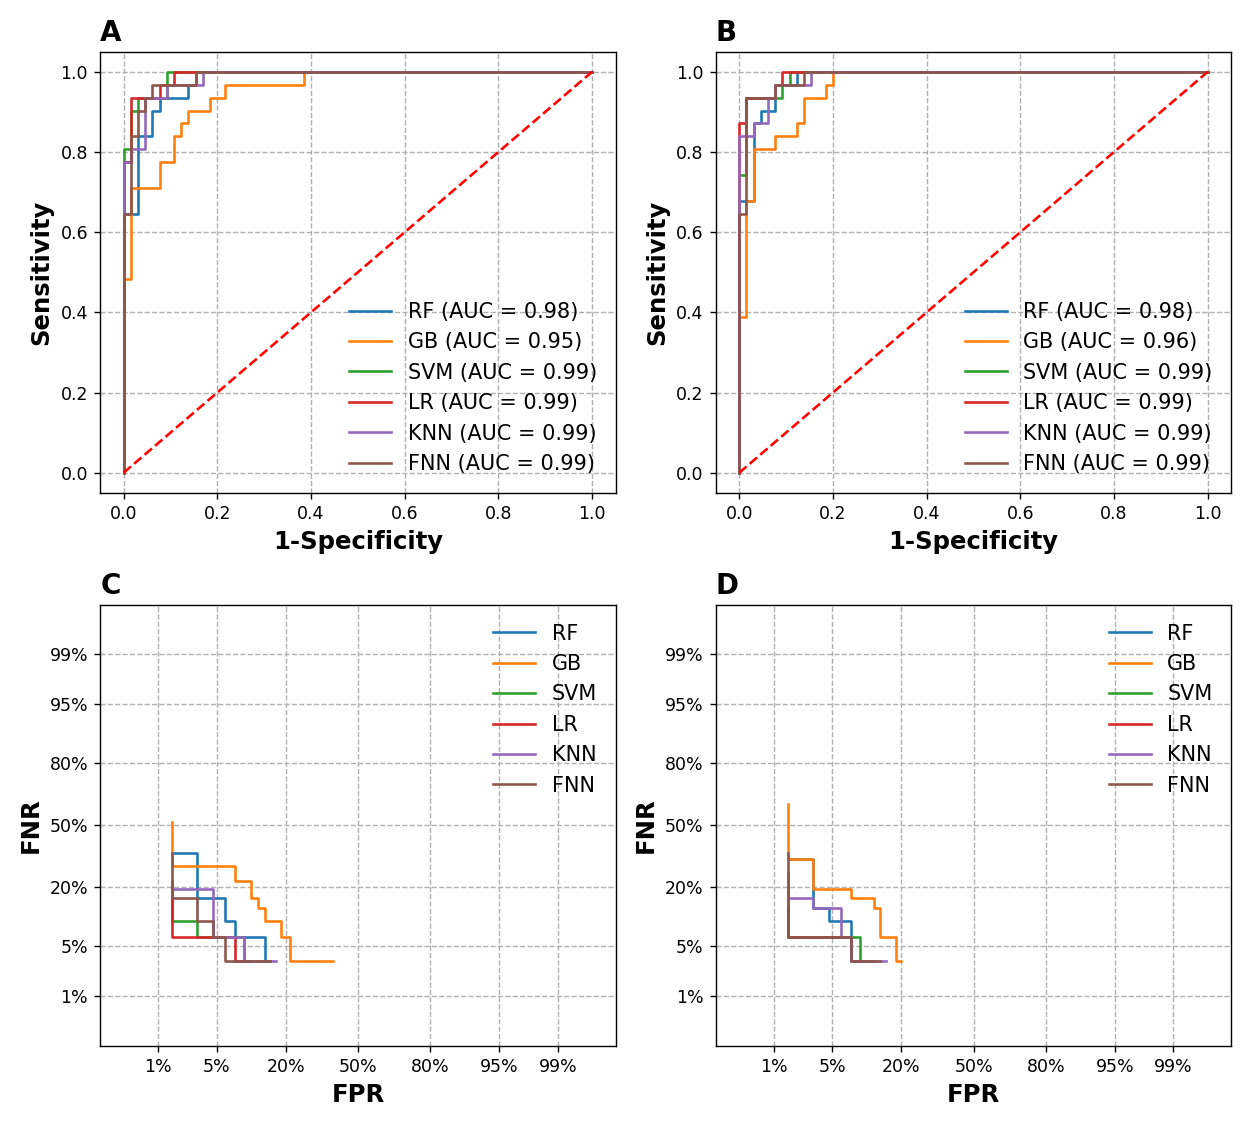

In [13]:
clfs_pca = [result["best Clf"] for model_name, result in method_1_results.items()]
clfs_tsvd = [result["best Clf"] for model_name, result in method_2_results.items()]

model_names = [model_name for model_name, result in method_1_results.items()]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=[10, 9])

for clf_pca, clf_tsvd, model_name in zip(clfs_pca, clfs_tsvd, model_names):
    # Plot the ROC curves
    RocCurveDisplay.from_estimator(clf_pca, X_test, y_test, ax=ax1, name=model_name)
    RocCurveDisplay.from_estimator(clf_tsvd, X_test, y_test, ax=ax2, name=model_name)
    # Plot the DET curves
    DetCurveDisplay.from_estimator(clf_pca, X_test, y_test, ax=ax3, name=model_name)
    DetCurveDisplay.from_estimator(clf_tsvd, X_test, y_test, ax=ax4, name=model_name)

ax1.set_title("A", fontsize=16, loc="left", fontweight="bold")
ax1.set_xlabel("1-Specificity", fontsize=14, fontweight="bold")
ax1.set_ylabel("Sensitivity", fontsize=14, fontweight="bold")
ax1.plot([0, 1], [0, 1], "r--")  # adding a diagonal
ax1.legend(fontsize=12, frameon=False)
ax1.grid(linestyle="--")
# ax1.grid(False)

ax2.set_title("B", fontsize=16, loc="left", fontweight="bold")
ax2.set_xlabel("1-Specificity", fontsize=14, fontweight="bold")
ax2.set_ylabel("Sensitivity", fontsize=14, fontweight="bold")
ax2.plot([0, 1], [0, 1], "r--")  # adding a diagonal
ax2.legend(fontsize=12, frameon=False)
ax2.grid(linestyle="--")
# ax2.grid(False)

ax3.set_title("C", fontsize=16, loc="left", fontweight="bold")
ax3.set_xlabel("FPR", fontsize=14, fontweight="bold")
ax3.set_ylabel("FNR", fontsize=14, fontweight="bold")
ax3.legend(fontsize=12, frameon=False)
ax3.grid(linestyle="--")
# ax3.grid(False)

ax4.set_title("D", fontsize=16, loc="left", fontweight="bold")
ax4.set_xlabel("FPR", fontsize=14, fontweight="bold")
ax4.set_ylabel("FNR", fontsize=14, fontweight="bold")
ax4.legend(fontsize=12, frameon=False)
ax4.grid(linestyle="--")
# ax4.grid(False)

fig.tight_layout()
# plt.savefig("../results/ROC and DET Curves for PCA and tSVD on Training Set.png", dpi=1200)
plt.show()